Attempting to download DEM for bounds: S=31.5, N=32.5, W=77.5, E=78.5
DEM downloaded/found: D:\Academics\Sem4\Geomorph\Final_Project\SRTMGL3_31.5_77.5_32.5_78.5.tif


c:\Users\Haarit\miniconda3\envs\py3.10\lib\site-packages\bmi_topography\api_key.py:48: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


DEM loaded into xarray.DataArray

--- Downloaded DEM Info ---
Shape: (1, 1200, 1200)
Resolution: (0.000833333333333144, -0.000833333333333144)
CRS: EPSG:4326
Bounds: (77.49958333327484, 31.500416666673146, 78.49958333327461, 32.50041666667292)
NoData value: 0
---------------------------

(1200, 1200)
No NoData values found.
Using DEM with shape: (1200, 1200)

Starting simulation for: ksp_3e-06_msp_0.5_nsp_1.0_diff_0.001_uplift_5e-03



KeyboardInterrupt: 

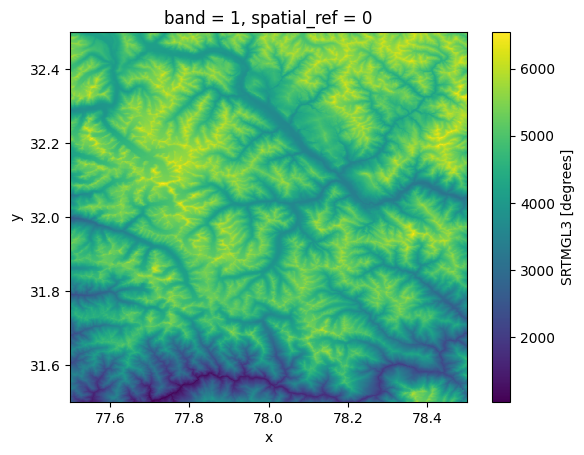

In [1]:
# Necessary imports
import bmi_topography
from bmi_topography import Topography
from landlab import RasterModelGrid
from landlab.components import (
    FlowAccumulator,
    FastscapeEroder,
    LinearDiffuser,
    SinkFiller,  # SinkFiller deals with depressions, including potential NoData pits if handled correctly
    ChiFinder,
    SteepnessFinder
)
from landlab.plot import imshow_grid
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import imageio
import os
import rioxarray  # Often used by bmi-topography, useful for nodata info
from itertools import product
import shutil

# --- Function to get Terrain Data ---
def getTerrain(south, north, west, east, cache_dir="."):
    """Downloads and loads DEM data using bmi-topography."""
    print(f"Attempting to download DEM for bounds: S={south}, N={north}, W={west}, E={east}")
    topo = Topography(
        dem_type="SRTMGL3",  # 3 arc-second (~90m) resolution SRTM
        south=south,
        north=north,
        west=west,
        east=east,
        output_format="GTiff",  # GeoTIFF format
        cache_dir=cache_dir,
    )
    fname = topo.fetch()
    print(f"DEM downloaded/found: {fname}")
    da = topo.load()  # Loads data as an xarray.DataArray
    print("DEM loaded into xarray.DataArray")
    # Ensure CRS is set if needed later, though landlab mainly uses grid coords
    if da.rio.crs is None:
        da.rio.write_crs("EPSG:4326", inplace=True)  # SRTM is usually WGS84
    return da

# --- Parameters for DEM extent ---
# Coordinates for the Baspa River area (Himachal Pradesh, India) - Example
lat_center, lon_center = 32, 78
buffer = 0.5  # Degrees (approx 33 km) - adjust as needed

south = lat_center - buffer
north = lat_center + buffer
west = lon_center - buffer
east = lon_center + buffer

# --- Simulation fixed parameters ---
dt = 500             # Time step [years]
nr_time_steps = 1000  # Number of time steps (total time = dt * nr_time_steps)
xy_spacing = 90      # meters (SRTMGL3 is ~90m resolution)

# --- Parameter arrays for combinations ---
K_sp_vals       = [3e-6]       # Stream power erodibility coefficients
m_sp_vals       = [0.5]           # Area exponent values
n_sp_vals       = [1.0]           # Slope exponent values
diffusivity_vals = [0.001]         # Linear diffusivities [m^2/yr]
uplift_vals     = [0.005]         # Uplift rates [m/yr]

# --- Get DEM Data once ---
da = getTerrain(south, north, west, east)
print("\n--- Downloaded DEM Info ---")
print(f"Shape: {da.shape}")
print(f"Resolution: {da.rio.resolution()}")
print(f"CRS: {da.rio.crs}")
print(f"Bounds: {da.rio.bounds()}")
print(f"NoData value: {da.rio.nodata}")
print("---------------------------\n")

da.plot()

# --- DEM Cleanup ---
# Extract elevation data (usually the first band)
dem_raw = da.data[0]
print(dem_raw.shape)

# Handle NoData values: Replace NaNs with the minimum valid elevation
nodata_val = da.rio.nodata
if nodata_val is not None:
    valid_mask = ~np.isnan(dem_raw) if np.isnan(nodata_val) else (dem_raw != nodata_val)
else:
    valid_mask = ~np.isnan(dem_raw)

if not np.all(valid_mask):
    print(f"Found NoData values ({nodata_val}). Replacing them.")
    min_valid_elevation = np.nanmin(dem_raw[valid_mask])
    print(f"Replacing NoData with minimum valid elevation: {min_valid_elevation:.2f}")
    dem_clean = np.where(valid_mask, dem_raw, min_valid_elevation)
else:
    print("No NoData values found.")
    dem_clean = dem_raw

# Store the clean DEM as the master copy (float64)
dem_master = np.array(dem_clean, dtype=np.float64)
nrows, ncols = dem_master.shape
print(f"Using DEM with shape: {dem_master.shape}")

# --- Outer loop over parameter combinations ---
for K_sp_val, m_sp_val, n_sp_val, diffusivity_val, uplift_val in product(K_sp_vals, m_sp_vals, n_sp_vals, diffusivity_vals, uplift_vals):

    # Create a unique tag for the parameter combination (you can refine the formatting)
    param_tag = f"ksp_{K_sp_val:.0e}_msp_{m_sp_val}_nsp_{n_sp_val}_diff_{diffusivity_val}_uplift_{uplift_val:.0e}"
    print("\n======================================")
    print(f"Starting simulation for: {param_tag}")
    print("======================================\n")

    # Create a dedicated folder for frames for this parameter combo
    output_dir = f"frames_{param_tag}"
    os.makedirs(output_dir, exist_ok=True)

    # --- Initialize simulation grid ---
    # Use a fresh copy of the DEM for each simulation run.
    dem = np.copy(dem_master)

    mg = RasterModelGrid((nrows, ncols), xy_spacing=xy_spacing)
    z = mg.add_field('topographic__elevation', dem.flatten(), at='node')

    # --- Initialize Landlab Components for this simulation ---
    sf = SinkFiller(mg, apply_slope=True)
    fr = FlowAccumulator(mg, flow_director='D8')
    ld = LinearDiffuser(mg, linear_diffusivity=diffusivity_val)
    fse = FastscapeEroder(mg, K_sp=K_sp_val, m_sp=m_sp_val, n_sp=n_sp_val)
    chif = ChiFinder(mg, min_drainage_area=0.0, reference_concavity=m_sp_val/n_sp_val)
    steepnessf = SteepnessFinder(mg, reference_concavity=m_sp_val/n_sp_val)

    # --- Uplift & Simulation Setup ---
    rock_up_rate = uplift_val  # Uplift rate [m/yr] for this run
    rock_up_len = rock_up_rate * dt  # Uplift per timestep [m]
    total_time = 0
    frame_count = 0

    # Pre-calculate limits for consistent color mapping
    initial_min_z = np.min(z)
    initial_max_z = np.max(z)
    max_possible_z = initial_max_z + rock_up_rate * dt * nr_time_steps
    plot_vmin = initial_min_z
    plot_vmax = max_possible_z

    # --- Main Evolution Loop for this simulation ---
    for i in range(nr_time_steps):
        # 1. Apply uplift to core nodes
        z[mg.core_nodes] += rock_up_len

        # 2. Hillslope diffusion
        ld.run_one_step(dt)

        # 3. Fill sinks before flow routing
        sf.run_one_step()

        # 4. Flow routing
        fr.run_one_step()

        # 5. Channel erosion
        fse.run_one_step(dt)

        total_time += dt

        # Optional: print progress (adjust frequency as needed)
        if i % (nr_time_steps // 20) == 0 or i == nr_time_steps - 1:
            print(f"[{param_tag}] Step {i}/{nr_time_steps}, Time: {total_time / 1000:.1f} kyr")

        # Save frame periodically (here ~50 frames are saved)
        if i % (nr_time_steps // 50) == 0 or i == nr_time_steps - 1:
            plt.figure(figsize=(10, 8))
            imshow_grid(mg, 'topographic__elevation',
                        plot_name=f'Elevation at {total_time / 1000:.1f} kyr',
                        allow_colorbar=True, cmap='terrain',
                        vmin=plot_vmin, vmax=plot_vmax)
            frame_filename = os.path.join(output_dir, f"frame_{frame_count:04d}.png")
            plt.savefig(frame_filename)
            plt.close()
            frame_count += 1

    print(f"\n[{param_tag}] Simulation finished. Creating GIF with {frame_count} frames...")

    # --- Create GIF for this simulation ---
    gif_filename = f"terrain_evolution_final_final.gif"
    try:
        with imageio.get_writer(gif_filename, mode='I', duration=0.2) as writer:
            for i in range(frame_count):
                frame_path = os.path.join(output_dir, f"frame_{i:04d}.png")
                if os.path.exists(frame_path):
                    image = imageio.v2.imread(frame_path)
                    writer.append_data(image)
                else:
                    print(f"Warning: Frame not found {frame_path}")
        print(f"[{param_tag}] GIF saved as {gif_filename}")
    except Exception as e:
        print(f"[{param_tag}] Error creating GIF: {e}")

    # --- Post-Simulation Analysis (optional) ---
    print(f"[{param_tag}] Running final routing & analysis...")
    sf.run_one_step()  # Fill final sinks
    fr.run_one_step()  # Update flow routing
    try:
        steepnessf.calculate_steepnesses(min_drainage_area=xy_spacing**2)
        chif.calculate_chi(min_drainage_area=xy_spacing**2)
        print(f"[{param_tag}] Analysis completed. Available node fields: {list(mg.at_node.keys())}")
    except Exception as e:
        print(f"[{param_tag}] Error in analysis: {e}")

    # --- Optionally: generate final plots for the simulation ---
    def plot_grid_final(field_name, title, label=None, cmap='viridis', vmin=None, vmax=None, use_log=False):
        plt.figure(figsize=(10, 8))
        data = mg.at_node[field_name]
        if use_log:
            valid_data = data[data > 0]
            if len(valid_data) == 0:
                plot_data = np.zeros_like(data)
            else:
                plot_data = np.log10(np.maximum(data, np.min(valid_data)*0.1))
                if label:
                    label = f"Log10({label})"
        else:
            plot_data = data

        if vmin is None and vmax is None:
            valid_plot_data = plot_data[np.isfinite(plot_data)]
            if len(valid_plot_data) > 0:
                vmin = np.percentile(valid_plot_data, 2)
                vmax = np.percentile(valid_plot_data, 98)
            else:
                vmin, vmax = 0, 1

        imshow_grid(mg, plot_data, plot_name=title, allow_colorbar=True,
                    colorbar_label=label, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.show()

    # Example final plot of topography (this will create a window for each simulation)
    plot_grid_final('topographic__elevation',
                    f'Final Topography ({total_time / 1e6:.2f} Myr) - {param_tag}',
                    label='Elevation (m)', cmap='terrain',
                    vmin=plot_vmin, vmax=plot_vmax)

    # Optional: Clean up the frames folder if you no longer need individual frames
    # shutil.rmtree(output_dir)

print("\nAll simulations finished.")
